# Implement Linear Regression with Numpy

This project is aimed to review some key point in linear regression. In order to show a completely raw, basic and primitive understanding, **no morden machine learning modules** (sklearn, pytorch) will be used. 

### Initialization
To start with, some modules are necessary to be loaded:
- `numpy` for matrix calculation
- `pandas` for data reading
- `matplotlib` for data visualization

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


### Step by Step
The whole process can be decomposed to the followin steps:
1. Load the data
2. analyse data, and deside which to predict
3. devide raw data into three part: train_set, dev_set, test_set.
    - both of them should set X and Y apart
4. build a linear regression model
5. train the model with test_set
    - graph the behaviour of cost function v.s. #\iteration
6. use dev_set to tune the hyperparameter `learning rate` and `lambda`
    - graph the behavious of cost function v.s. #\iteration
    - list out the accuracy of each learning rate
7. test the final result by test_set
    - graph the behavious of cost function v.s. #\iteration
    - list out the accuracy of each learning rate
8. list a big chart to compare test accuracy, dev accuracy, test accuracy
    - overfitting? (high variance)
    - underfitting? (high biaes)

In [2]:
# load data
df = pd.read_csv("assets/Boston.csv", index_col=0) # set first column as index. also can be directly droped
print(df.head()) # Overview of raw data
print(df.shape) # Number of features(n) & Number of examples(m)
print(df.columns) # What are the features? 

      crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
1  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
2  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
3  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
4  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
5  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

    black  lstat  medv  
1  396.90   4.98  24.0  
2  396.90   9.14  21.6  
3  392.83   4.03  34.7  
4  394.63   2.94  33.4  
5  396.90   5.33  36.2  
(506, 14)
Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'black', 'lstat', 'medv'],
      dtype='object')


### Data analysis
Raw data consists of 14 features with 506 examples. Thats quite a few data size, so no wonder it may perform badly. 
The 14 features are (please forgive my chinese):
*   **crim**: 城镇人均犯罪率
*   **zn**: 占地面积超过25,000平方英尺的住宅用地比例
*   **indus**: 每个城镇的非零售商业用地所占比例
*   **chas**: 是否临近查尔斯河的虚拟变量（如果临河则为1，否则为0）
*   **nox**: 一氧化氮浓度（单位：千万分之一）
*   **rm**: 每户住宅的平均房间数
*   **age**: 1940年以前建成的自有住房比例
*   **dis**: 到波士顿五个就业中心的加权距离
*   **rad**: 到放射状高速公路的可达性指数
*   **tax**: 每10,000美元的全额房产税率
*   **ptratio**: 城镇的师生比例
*   **black**: 计算公式为 1000(Bk - 0.63)^2，其中Bk是城镇中黑人居民的比例
*   **lstat**: 人口中“低社会经济地位”的百分比
*   **medv**: 自有住房的中位数价值（单位：1000美元）

I plan to predict **medv** by other 13 features. 

<!-- To be frankly, I would not consider so much if I am purchasing a house. 
- **chas** seems a rediculous feature. Maybe it is a "mother river" for Boston locals?
- **nox** is totally unrealiable. If $NO$ should be considered, then other harmful gas, like $CO_{2}, CO, PM2.5, PM10$, should be involved as well.

Both of them will be droped off. -->


In [3]:
# drop & randomly shuffle the rows, random state makes result reproductable
def drop_and_shuffle(df, drop_colums:list, random_state=42):
    df_drop = df.drop(columns=drop_colums)
    df_drop_and_shuffle = df_drop.sample(frac=1, random_state=random_state) 
    return df_drop_and_shuffle

In [4]:
df_drop_and_shuffle = drop_and_shuffle(df, drop_colums=[])
df_drop_and_shuffle.head()

crim    zn  indus  chas    nox     rm   age     dis  rad  tax  \
174  0.09178   0.0   4.05     0  0.510  6.416  84.1  2.6463    5  296   
275  0.05644  40.0   6.41     1  0.447  6.758  32.9  4.0776    4  254   
492  0.10574   0.0  27.74     0  0.609  5.983  98.8  1.8681    4  711   
73   0.09164   0.0  10.81     0  0.413  6.065   7.8  5.2873    4  305   
453  5.09017   0.0  18.10     0  0.713  6.297  91.8  2.3682   24  666   

     ptratio   black  lstat  medv  
174     16.6  395.50   9.04  23.6  
275     17.6  396.90   3.53  32.4  
492     20.1  390.11  18.07  13.6  
73      19.2  390.91   5.52  22.8  
453     20.2  385.09  17.27  16.1

### Split the data
The whole 506 examples will be devided into 3 parts:
- Train: accounts for 70% ($m_{train} = 354$), used for model training. 
- Dev: accounts for 20% ($m_{dev} = 101$), used for examing the effect, tuning the hyperparameters. 
- Test: accounts for 10% ($m_{test} = 51$), used for testingt the ultimate performance. 

In [5]:
# split the dataset
# train : dev : test = 7 : 2 : 1
def df_split(df, train_ratio:float, dev_ratio:float):
    num_of_rows = df.shape[0]
    comma_1 = int(num_of_rows * train_ratio)
    comma_2 = int(num_of_rows * (train_ratio + dev_ratio))
    df_train = df[:comma_1][:]
    df_dev = df[comma_1:comma_2][:]
    df_test = df[comma_2:][:]
    return [df_train, df_dev, df_test]


In [6]:
df_splits = df_split(df_drop_and_shuffle, train_ratio=0.7, dev_ratio=0.2)
df_train, df_dev, df_test = df_splits
print(df_train.shape, df_dev.shape, df_test.shape)

(354, 14) (101, 14) (51, 14)


Each part contains both features(X) and result(Y), so they have to be split out again. 

If $ \# \text{feature} = n, \# \text{example} = m$, then:
- $$ X \in \mathbb{R}^{n \times m}, Y \in \mathbb{R}^{1 \times m}$$
- $$X = \begin{bmatrix} x_{1}^{(1)} & x_{1}^{(2)} & x_{1}^{(\dots)} & x_{1}^{(m)} \\ x_{2}^{(1)} & x_{2}^{(2)} & x_{2}^{(\dots)} & x_{2}^{(m)} \\ x_{\cdots}^{(1)} & x_{\cdots}^{(2)} & x_{\cdots}^{\cdots} & x_{\cdots}^{(m)}\\  x_{n}^{(1)} & x_{n}^{(2)} & x_{n}^{(\dots)} & x_{n}^{(m)} \end{bmatrix}$$
- $$Y = \begin{bmatrix} y^{(1)} & y^{(2)} & y^{(\cdots)} & y^{(m)} \end{bmatrix}$$

Subscripts indicate feature numbers, and superscripts in parentheses indicate example numbers.

Since the raw data happen to be the transpose of target matrix, I transpose all of them when spliting.

In [7]:
# split features and predic indecators
def set_split_to_array(df, drop_feature:list):
    X = df.drop(labels=drop_feature, axis=1).to_numpy().T # drop out the price, axis=1 means vertially
    Y = df.loc[:][drop_feature].to_numpy().T.reshape(1,-1) # dimention is important.
    return X, Y


In [8]:
X_train, Y_train = set_split_to_array(df_train, drop_feature=['medv'])
X_dev, Y_dev = set_split_to_array(df_dev, drop_feature=['medv'])
X_test, Y_test = set_split_to_array(df_test, drop_feature=['medv'])
X_list = [X_train, X_dev, X_test]
Y_list = [Y_train, Y_dev, Y_test]

print(X_dev) # test the spliting

[[1.08342e+01 6.90500e-02 1.53800e-02 ... 7.50300e-02 5.69175e+00
  4.75470e-01]
 [0.00000e+00 0.00000e+00 9.00000e+01 ... 3.30000e+01 0.00000e+00
  0.00000e+00]
 [1.81000e+01 2.18000e+00 3.75000e+00 ... 2.18000e+00 1.81000e+01
  9.90000e+00]
 ...
 [2.02000e+01 1.87000e+01 1.59000e+01 ... 1.84000e+01 2.02000e+01
  1.84000e+01]
 [2.15700e+01 3.96900e+02 3.86340e+02 ... 3.96900e+02 3.92680e+02
  3.96230e+02]
 [2.57900e+01 5.33000e+00 3.11000e+00 ... 6.47000e+00 1.49800e+01
  1.27300e+01]]


### Linear Regression - Front prop
Linear regression is the basic supervise learning algorithm. It can learn and abstract info and features from training examples to the parameters (weights $W$ and bias $b$), where:
$$W = \begin{bmatrix} w_{1} \\ w_{2} \\ w_{3} \\ w_{\cdots} \\ w_{n} \\  \end{bmatrix} \in \mathbb{R}^{n \times 1}$$
$$b = \text{constant} \in \mathbb{R}$$
Generally, we can predict target features by a linear function:
$$\hat{Y} = h(X) = W^{T}X+b \text{(broadcast b to matrix)}$$

To evaluate prediction, a Cost function $J(W, b)$ is introduced:
$$J(W, b) = \frac{1}{2m} (\hat{Y} - Y)(\hat{Y} - Y)^{T}$$

Ordinary least squares points out a way to minimize $J$:
$$ \frac{\partial J}{\partial W}=0, \frac{\partial J}{\partial b}=0 \rightarrow w = (X_cᵀX_c)⁻¹X_cᵀy_c, b = ȳ - wᵀx̄$$

Or adding a penalty, we obtain a Objective Function:
$$J(W, b) = \frac{1}{2m} (\hat{Y} - Y)(\hat{Y} - Y)^{T}+ \frac{\lambda}{2m} ||W^{2}|| $$
The closer $\hat{Y}, Y$ are, the smaller the $J$ is. The final goal is to minimize $J$

$\lambda$ is the penalty. 

In [9]:
# it is okay to set all to 0 in linear regression
def initialize(X):
    n = X.shape[0]
    W = np.zeros((n,1)) # dim is important!!!
    b = 0
    return W, b

def frontprop(W, X, b:float):
    Y_predict = W.T @ X + b
    return Y_predict


def cost(Y_predict, Y, W, lamda):
    m = Y_predict.shape[1]
    cost_func = float(((Y_predict - Y) @ (Y_predict - Y).T).item()) / (2*m) + (lamda/(2*m))*(np.sum(W**2))
    return cost_func



### Visualize Gradient Descent

What does Cost function look like? Take data with only 2 features ($x_{1}, x_{2}$) as an example, then $J$ can be simplified as (ignore the penalty $\lambda$ and bias $b$ here):
$$J = \frac{1}{2m} \sum_{i=1}^{m} (y^{(i)} - w_{1}x_{1}^{(i)}-w_{2}x_{2}^{(i)})^{2}$$

Obviously, $J$ is a quadratic function of both $w_{1}^{(i)}$ and $w_2^{(i)}$

Assume:
$$n=2, m=2, b=0$$
$$W = \begin{bmatrix} w_{1} \\ w_{2} \end{bmatrix}$$
$$X = \begin{bmatrix} 5 & 0 \\ 0 & 2 \end{bmatrix}$$
$$Y = \begin{bmatrix} 5 & 4 \end{bmatrix}$$
and the function of $J$ with respect to $w_{1}, w_{2}$ is: 
$$J(w_{1}, w_{2}) = \frac{1}{4} [(5-5 \cdot w_{1}-0 \cdot w_{2})^{2} + (4-0 \cdot w_{1}-2 \cdot w_{2})^{2}]$$
and:

Then graph it out:

In [10]:
# AI generated
# 3D plot
def J_visialize():
    w1 = np.linspace(0, 2, 50)
    w2 = np.linspace(0, 4, 50)
    w1, w2 = np.meshgrid(w1, w2)
    J = 0.25 * ((5 - 5*w1)**2 + (4 - 2*w2)**2)
    fig = plt.figure(figsize=(18, 5))

    # -------------------------
    # 1. 3D 曲面图
    # -------------------------
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    ax1.plot_surface(w1, w2, J, cmap="RdYlGn")
    ax1.set_title("3D Surface")
    ax1.set_xlabel("w1")
    ax1.set_ylabel("w2")
    ax1.set_zlabel("J")

    # -------------------------
    # 2. 等高线图
    # -------------------------
    ax2 = fig.add_subplot(1, 3, 2)
    contours = ax2.contour(w1, w2, J, levels=30)
    ax2.clabel(contours, inline=True, fontsize=8)
    ax2.set_title("Contour Plot")
    ax2.set_xlabel("w1")
    ax2.set_ylabel("w2")

    # -------------------------
    # 3. 热力图
    # -------------------------
    ax3 = fig.add_subplot(1, 3, 3)
    im = ax3.imshow(J, origin='lower', aspect='auto')
    plt.colorbar(im, ax=ax3)
    ax3.set_title("Heatmap")
    ax3.set_xlabel("w1")
    ax3.set_ylabel("w2")

    plt.tight_layout()


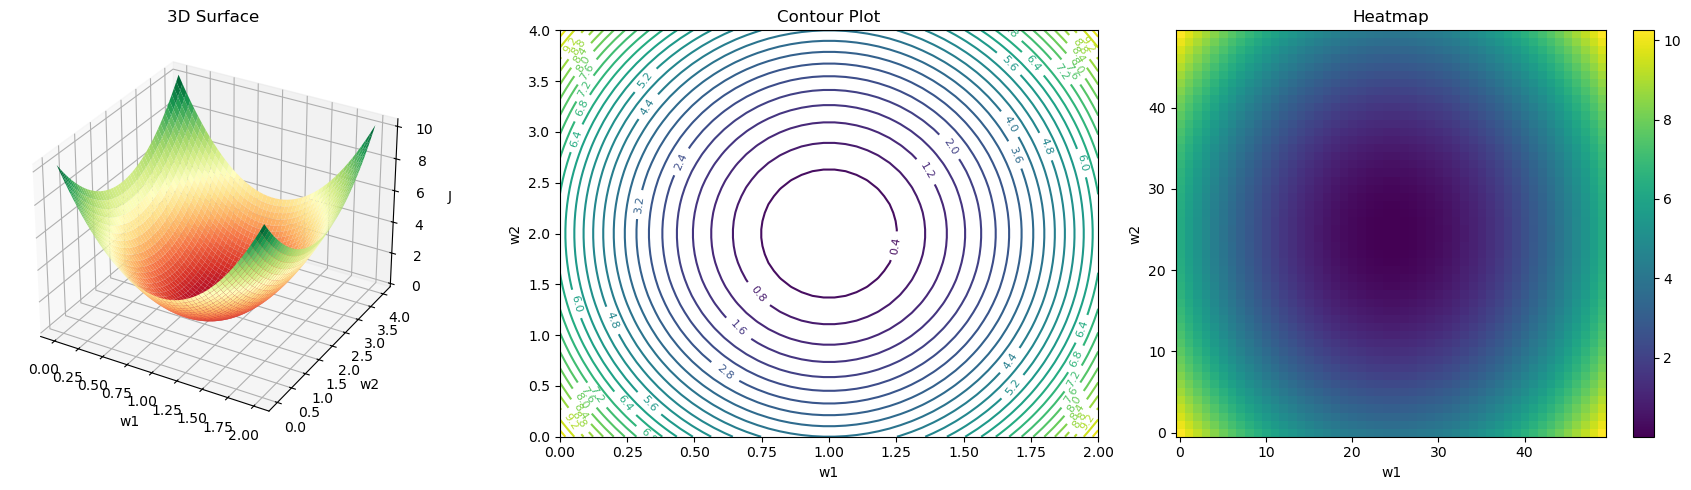

In [11]:
J_visialize()

It is obvious to figure out that $w_{1}=1$ and $w_{2}=2$ can minimize $J$ to 0. However, when dealing with multiple examples and features, you cannot find the best solution through your eyes, but through fundamental math calculation: **gradient descent**. It is quite similar to **Newton's Method** in Calculus I, but some details are different. In general, it is an effective approach to minimize a multi-variable function.

### Gradient Descent
As seen in the graph, our goal is the "valley" point. Imagine J is a mountain, and we descent along the incline to reach the lowest point. Since the derivative of J is the slope of incline, we determin the descent direction through derivative. If it's bigger than 0, we head to the opposite direction to go down; if smaller than 0, then head to the same direction to go down. **In general, our direction is opposite to derivative.** 

Then how big the step we should take? That's the main difference between Gradient Descent and Newton's Method:
|Aspects|Gradient Descent|Newton's Method|
|:------|:---------------|:--------------|
|Formula|$W := W - \alpha \frac{\partial J}{\partial W}$|$W := W - [{\frac{\partial^{2} J}{\partial W^{2}}}]^{-1} \frac{\partial J}{\partial W}$|
|Meaning|Head to the lowest point with constant step length|Head to the lowest point with step length equals to curvature at that point|
|Geometric interpretation|Replace curved surface with plane|Replace curved surface with quadratic surface|
|Learning Rate|Fixed constant|Dynamic|
|Computational Cost|Small|Big|

In [12]:
# Record dots during descent
def visualize_linear_regression(start_point, learning_rate):
    dots = []
    w1, w2 = start_point
    iteration = 0
    while (abs(w1 - 1) >= 1e-9 or abs(w2-2) >= 2 * 1e-9) and iteration < 10000: 
        # simplified linear regression
        iteration += 1
        dots.append((w1, w2))
        w1 -= learning_rate * 12.5 * (w1 - 1) # dJ/dw1
        w2 -= learning_rate * (2 * w2 - 4) # dJ/dw2
    return dots, iteration

# plot the figure, dots and arrow
def plot_gradient_descent(ax, start_point, learning_rate):
    w1 = np.linspace(-0.08, 2.08, 55)
    w2 = np.linspace(-0.16, 4.16, 55)
    w1, w2 = np.meshgrid(w1, w2)
    J = 0.25 * ((5 - 5*w1)**2 + (4 - 2*w2)**2)
    contours = ax.contour(w1, w2, J, levels=30)
    ax.clabel(contours, inline=True, fontsize=8)
    dots, iteration = visualize_linear_regression(start_point=start_point, learning_rate=learning_rate)
    ax.scatter([x for x, y in dots], [y for x, y in dots])
    for i in range(len(dots)-1):
        ax.arrow(dots[i][0], dots[i][1], dots[i+1][0]-dots[i][0], dots[i+1][1]-dots[i][1], head_width=0.05, head_length=0.1, fc='blue', ec='blue')
    ax.set_title(f"{start_point}, a={learning_rate}, #i={iteration}", fontsize=10)
    print(f"start point={start_point}, learning_rate={learning_rate}, #iteration={iteration}")
    ax.set(xticklabels=[], yticklabels=[])

def plot_all():
    learning_rate_list = [0.01, 0.02, 0.05, 0.1]
    start_point_list = [(0,0),(1,0),(2,3),(2,4)]
    fig, ax = plt.subplots(len(learning_rate_list), len(start_point_list), figsize=(16, 14))
    for i in range(len(learning_rate_list)):
        for j in range(len(start_point_list)):
            plot_gradient_descent(ax[i][j], start_point_list[j], learning_rate_list[i])
    fig.suptitle("Visualization of Gradient Descent", fontsize=24)
    fig.tight_layout()


start point=(0, 0), learning_rate=0.01, #iteration=1026
start point=(1, 0), learning_rate=0.01, #iteration=1026
start point=(2, 3), learning_rate=0.01, #iteration=992
start point=(2, 4), learning_rate=0.01, #iteration=1026
start point=(0, 0), learning_rate=0.02, #iteration=508
start point=(1, 0), learning_rate=0.02, #iteration=508
start point=(2, 3), learning_rate=0.02, #iteration=491
start point=(2, 4), learning_rate=0.02, #iteration=508
start point=(0, 0), learning_rate=0.05, #iteration=197
start point=(1, 0), learning_rate=0.05, #iteration=197
start point=(2, 3), learning_rate=0.05, #iteration=191
start point=(2, 4), learning_rate=0.05, #iteration=197
start point=(0, 0), learning_rate=0.1, #iteration=93
start point=(1, 0), learning_rate=0.1, #iteration=93
start point=(2, 3), learning_rate=0.1, #iteration=90
start point=(2, 4), learning_rate=0.1, #iteration=93


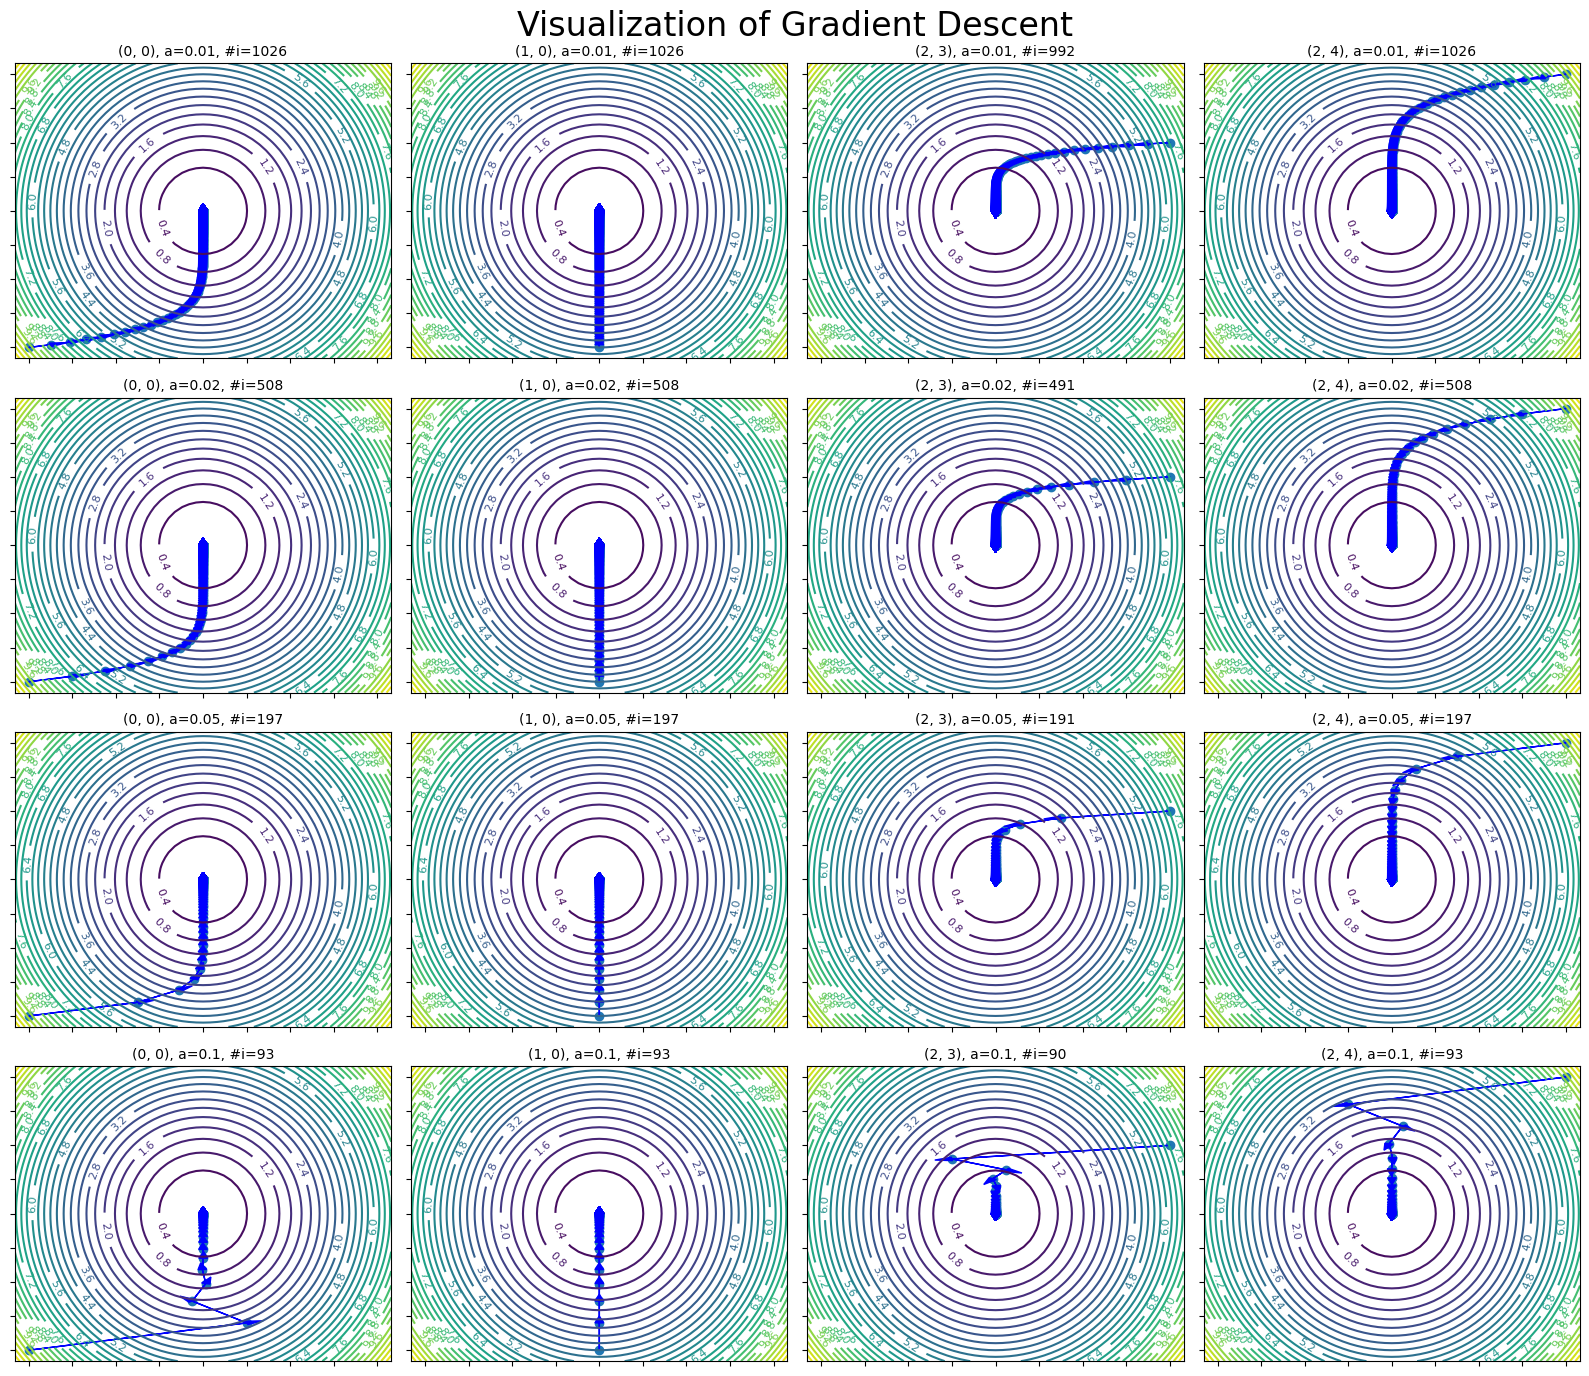

In [13]:
plot_all()

The result is straight forward. All paths are heading to the lowest point. That is the main point of gradient descent. 

### Linear Regression - Back prop
The formal gradient descent, in linear regression, is the conclusions as follows:

First calculate dz, which is an essential pattern:
$$dz = \hat{Y} - Y$$
then calculate dw, db:
$$ dW = \frac{\partial J}{\partial W} = \frac{1}{m} X dz^{T} $$

$$ db = \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} dz_{i} $$
Inspired by that, I write down the following code.

In [14]:
def backprop(Y_predict, Y, W, X, b:float, learning_rate:float, lamda) -> np.array:
    m = X.shape[1] # number of examples
    dz = Y_predict - Y 
    dw = X @ dz.T / m
    db = np.sum(dz) / m
    W_modifyed = (1 - learning_rate*lamda / m)*W - learning_rate * dw
    b_modifyed = b - learning_rate * db
    return W_modifyed, b_modifyed

### Standardization, Normalization and Regularization
- Standardization transfer data to a distribution with mean=0 and variance=1:
$$Z = \frac{X-\mu}{\sigma} $$
- Normalization restrict data with a certain domain, usually [-1, 1]:
$$Z = \frac{X-\mu}{X_{max}-X_{min}} $$
- Regularization: penalty $\lambda$, which prevent model from overfitting
    - L1 Regularization: sum of absolute value of each weights in $W$
    - L2 Regularization: sum of square value of each weights in $W$

Of course, after trying, I found that the raw data should be restricted, and standardization performs much better than normalization, perhaps too many extremely high/low value disturb it. What's more, initial results shows a severe overfitting, so introducing L2 regularzation is also a must. 

In [15]:
# performance is much better.
def standardization(arr):
    row_avg = np.mean(arr, axis=1, keepdims=True)
    row_std = np.std(arr, axis=1, keepdims=True)
    arr_norm = (arr - row_avg) / (row_std + 1e-9)
    return arr_norm, row_avg, row_std

def linear_regression(X, Y, iterations, learning_rate, lamda):
    W, b = initialize(X)
    X_norm, X_avg, X_std = standardization(X)
    Y_norm, Y_avg, Y_std = standardization(Y)
    
    process = []
    for i in range(iterations):
        Y_predict = frontprop(W, X_norm, b)
        cost_val = cost(Y_predict, Y_norm, W, lamda)
        process.append((i+1, cost_val))
        if i%1000 == 0:
            print(f"{i+1}th iteration, cost = {cost_val}")
        W, b = backprop(Y_predict, Y_norm, W, X_norm, b, learning_rate, lamda)
    cache = {"W":W, "b":b, "X_avg":X_avg, "X_std":X_std, "Y_avg":Y_avg, "Y_std":Y_std}
    return process, cache

In [16]:
# plot graph: cost vs. iterations
def train_data_plot(process):
    # plot the result of training set
    plt.plot([i for i,j in process], [j for i,j in process], label="Training Set")
    plt.xlabel("#Iterations")
    plt.ylabel("Cost")
    plt.title("Cost vs. #Iterations")
    plt.legend()
    plt.grid(True)

In [17]:
# make predictions based on trained parameters
def predict(X, cache):
    W,b = cache["W"], cache["b"]
    X_avg, X_std, Y_avg, Y_std = cache["X_avg"], cache["X_std"], cache["Y_avg"], cache["Y_std"]
    X_norm = (X - X_avg) / (X_std + 1e-9)
    Y_predict = frontprop(W, X_norm, b)
    Y_predict = Y_predict * (Y_std + 1e-9) + Y_avg
    return Y_predict

Finally, it is time to train our model!

In [18]:
# train the model
process, cache = linear_regression(
    X_train, Y_train, 
    iterations = 10000, 
    learning_rate = 0.001, 
    lamda =0 )

1th iteration, cost = 0.499999999891836
1001th iteration, cost = 0.16578630540564343
2001th iteration, cost = 0.14587069402115618
3001th iteration, cost = 0.14018202289649495
4001th iteration, cost = 0.1372125634482378
5001th iteration, cost = 0.13523847548769097
6001th iteration, cost = 0.13382517416453457
7001th iteration, cost = 0.13278346166965665
8001th iteration, cost = 0.13200167881310162
9001th iteration, cost = 0.13140600009735645


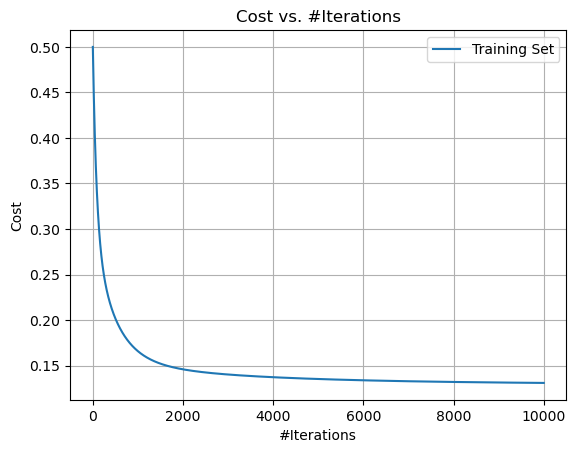

In [19]:
train_data_plot(process)

### Evaluate the Predictions
I introduced two standards:
1. Coefficient of Determination:
It reflects the goodness of fit. Generally speaking, it answers the question:
>How well your model fit the origin data?
$$R^{2} = \frac{SS_{reg}}{SS_{tot}} = 1 - \frac{SS_{res}}{SS_{tot}}=1 - \frac{\sum_{i=1}^{m} (y^{(i)}-\hat{y}^{(i)})^{2}}{\sum_{i=1}^{m}(y^{(i)}-\bar{y})^{2}} $$
- $SS_{res}$: square sum of residual errors, errors that the model makes.
$$ SS_{res} = \sum_{i=1}^{m} (y^{(i)}-\hat{y}^{(i)})^{2} $$
- $SS_{reg}$: square sum due to regression, how well the model predicts.
$$ SS_{reg} = \sum_{i=1}^{m} (\hat{y}^{(i)}-\bar{y})^{2} $$
- $SS_{tot}$: square sum in total. Since a **most secure and conservative prediction is the mean value** -- We can make this prediction without hesitation --, we consider the difference between real and mean as the base error. If prediction is even worse than guessing the mean, then your model is really bad for sure. obviously $$SS_{tot} = \sum_{i=1}^{m} (y^{(i)}-\bar{y})^{2} = \sum_{i=1}^{m} (y^{(i)}-\hat{y}^{(i)}+\hat{y}^{(i)}-\bar{y})^{2}  = 
 \sum_{i=1}^{m} (y^{(i)}-\hat{y}^{(i)})^{2} + \sum_{i=1}^{m} (\hat{y}^{(i)}-\bar{y})^{2} + 
 2\sum_{i=1}^{m} (y^{(i)}-\hat{y}^{(i)}) (\hat{y}^{(i)}-\bar{y}) $$
 When using **Ordinary least squares** regression, 
$$\frac{\partial J}{\partial \hat{Y}} = 2\sum_{i=1}^{m} (\hat{y}^{(i)}-y^{(i)})=0 \rightarrow \sum_{i=1}^{m} (\hat{y}^{(i)}-y^{(i)})= 0$$
$$ \frac{\partial J}{\partial w_{j}} = 2 \sum_{i=1}^{m} (\hat{y}^{(i)}-y^{(i)})x^{(i)}_{j} = 0 \rightarrow \sum_{i=1}^{m} (\hat{y}^{(i)}-y^{(i)})\hat{y}^{(i)} = \sum_{i=1}^{m} [\sum_{j=1}^{n} w_{j}(\hat{y}^{(i)}-y^{(i)})x^{(i)}_{j} + b(y^{(i)} - \hat{y}^{(i)})] = 0$$
Thus:
$$ 2\sum_{i=1}^{m} (y^{(i)}-\hat{y}^{(i)}) (\hat{y}^{(i)}-\bar{y}) = 0 \rightarrow \therefore SS_{tot} = \sum_{i=1}^{m} (y^{(i)}-\hat{y}^{(i)})^{2} + \sum_{i=1}^{m} (\hat{y}^{(i)}-\bar{y})^{2} = SS_{res} + SS_{reg}$$

However, gradient descent not always reaches the best solution, thus usually $SS_{tot} \geq SS_{res} + SS_{reg}$, and $R^{2} = 1 - SS_{res}/SS_{tot}$

According to the formula, COD actually shows the percentage that regression errors accounts for. 
- $R^{2}$ is smaller than 0, then model makes a significant mistake, since a stupit repeater can perform much more better.
- $R^{2}$ is close to 0, then almost all the error is unknown, the model do not make a good prediction.
- $R^{2}$ is close to 1, then almost no error exists, the model do a great job.

2. Root Mean Square Error

Literally, it is the mean value of $SS_{res}$, evaluates the average mistake:
$$RMSE = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)}-y^{(i)})^{2}$$

In [20]:
# Coefficient of Determination
def COD(Y_true, Y_predict):
    ssres = np.sum((Y_true - Y_predict)**2)
    sstot = np.sum((Y_true - np.mean(Y_true))**2)
    return 1 - ssres / sstot

# Root Mean Square Error
def RMSE(Y_true, Y_predict):
    return np.mean((Y_true - Y_predict)**2)**0.5


Then we check the performance:

In [21]:
def evaluation(X_list, Y_list, cache, test=False):
    X_train, X_dev, X_test = X_list
    Y_train, Y_dev, Y_test = Y_list
    
    res = {
        "predict": {}, 
        "COD": {}, 
        "RMSE": {}
    }

    Y_train_predict = predict(X_train, cache)
    COD_train = COD(Y_train, Y_train_predict)
    RMSE_train = RMSE(Y_train, Y_train_predict)
    res["predict"]["train"] = Y_train_predict
    res["COD"]["train"] = COD_train
    res["RMSE"]["train"] = RMSE_train

    Y_dev_predict = predict(X_dev, cache)
    COD_dev = COD(Y_dev, Y_dev_predict)
    RMSE_dev = RMSE(Y_dev, Y_dev_predict)
    res["predict"]["dev"] = Y_dev_predict
    res["COD"]["dev"] = COD_dev
    res["RMSE"]["dev"] = RMSE_dev

    if test:
        Y_test_predict = predict(X_test, cache)
        COD_test = COD(Y_test, Y_test_predict)
        RMSE_test = RMSE(Y_test, Y_test_predict)
        res["predict"]["test"] = Y_test_predict
        res["COD"]["test"] = COD_test
        res["RMSE"]["test"] = RMSE_test
    
    if test:
        print(f"Coefficient of Determination: train = {COD_train}, dev = {COD_dev}, test = {COD_test}")
        print(f"Root Mean Square Error: train = {RMSE_train}, dev = {RMSE_dev}, test = {RMSE_test}")
    else:
        print(f"Coefficient of Determination: train = {COD_train}, dev = {COD_dev}")
        print(f"Root Mean Square Error: train = {RMSE_train}, dev = {RMSE_dev}")
    
    return res
    

In [22]:
res_temp = evaluation(X_list, Y_list, cache, test=False)

Coefficient of Determination: train = 0.7381088684939219, dev = 0.7800099863224144
Root Mean Square Error: train = 4.731278531875681, dev = 4.451986779519225


Result:
|Catagory|$R^{2}$|$RMSE$|
|:-------|:------|:-----|
|Train   |0.7381 |4.7313|
|Dev     |0.7800 |4.4520|

<span style="font-size: 100px;"> WTF??? </span>

Dev set is even better than train set? Then what about the test set? 

In [23]:
res = evaluation(X_list, Y_list, cache, test=True)
Y_train_predict, Y_dev_predict, Y_test_predict = list(res["predict"].values())

Coefficient of Determination: train = 0.7381088684939219, dev = 0.7800099863224144, test = 0.611198826886182
Root Mean Square Error: train = 4.731278531875681, dev = 4.451986779519225, test = 5.030764511845791


Result:
|Catagory|$R^{2}$|$RMSE$|
|:-------|:------|:-----|
|Train   |0.7381 |4.7313|
|Dev     |0.7800 |4.4520|
|Test    |0.6112 |5.0308|

The result shows that: model is overfitting to the dev set, leading to a worse performance on test set. 

Why? I have a few hypothesis:
1. Systemetic errors exist, i.e. linear function cannot describe relationship appropriately. 
2. Som useless features disturb my model.

### H1: Systemetic errors: graph of residual errors vs. medv

In [24]:
def find_sepecial(df_test, Y_test_predict, Y_test, chosen_feature='predict'):
    Y_test_predict_res = Y_test_predict - Y_test # get the residual errors
    mean_res = np.mean(Y_test_predict_res).item()
    std_res = np.std(Y_dev_predict).item()
    
    if chosen_feature != 'predict':
        X_feature = df_test[chosen_feature].to_numpy()
        df_test_res_dict = {
            "res": Y_test_predict_res.ravel(), 
            chosen_feature: X_feature.ravel()
            } # construct for sorting in pairs
        df_test_res = pd.DataFrame(df_test_res_dict, columns=["res", chosen_feature], index=df_test.index) 
    else:
        df_test_res_dict = {
            "res": Y_test_predict_res.ravel(), 
            "predict": Y_test_predict.ravel()
            } # construct for sorting in pairs
        df_test_res = pd.DataFrame(df_test_res_dict, columns=["res", "predict"], index=df_test.index) 
    
    outliers = df_test_res[abs(df_test_res['res'] - mean_res) > 1.4 * std_res] # may have some bad predictions
    normals = df_test_res[abs(df_test_res['res'] - mean_res) < 0.1 * std_res] # may have some good predictions
    
    return outliers, normals, df_test_res

def plot_res_graph(df_test, Y_test_predict, Y_test, chosen_feature='predict'):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    plot_res_subplot(ax, df_test, Y_test_predict, Y_test, chosen_feature)
    fig.tight_layout()

def plot_res_subplot(ax, df_test, Y_test_predict, Y_test, chosen_feature='predict'):
    outliers, normals, df_test_res = find_sepecial(df_test, Y_test_predict, Y_test, chosen_feature)
    ax.axhline(y=0, color="#919191", linestyle='--', linewidth=2)
    ax.scatter(df_test_res[chosen_feature], df_test_res["res"], label="so-so", color="#30B7EDF4")
    ax.scatter(outliers[chosen_feature], outliers["res"], label="bad", color="#F81E13F4")
    ax.scatter(normals[chosen_feature], normals["res"], label="good", color="#1CF308F4")

    ax.set_xlabel(chosen_feature)
    ax.set_ylabel("residual error")
    ax.set_title(f"Residual Error vs. {chosen_feature}")
    ax.grid(visible=True, axis='both', linestyle=":")
    ax.legend()


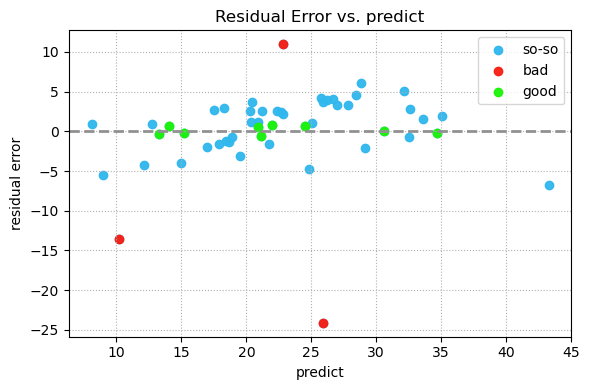

In [25]:
plot_res_graph(df_test, Y_test_predict, Y_test, chosen_feature='predict')

The plots reveals some significant insights:
1. No severe Heteroskedasticity(异方差), which means residual error is independent to medv
2. The overall distribution is like $\cap$, thus relationship between origin data and medv may not be **purely linear**.
3. Some Outliers(离群点) exist. 

I now dive into those outliers. 

In [26]:
def compare_df(df_test, Y_test_predict, Y_test):
    outliers, normals, _ = find_sepecial(df_test, Y_test_predict, Y_test)
    outliers_index = list(outliers.index)
    normals_index = list(normals.index)
    outliers_data = df_test.loc[outliers_index][:]
    normals_data = df_test.loc[normals_index][:]

    outliers_data_sta = pd.concat([outliers_data.mean(axis=0), outliers_data.max(axis=0), outliers_data.min(axis=0)],axis=1)
    outliers_data_sta.columns=['mean_out', 'max_out', 'min_out']

    normals_data_sta = pd.concat([normals_data.mean(axis=0), normals_data.max(axis=0), normals_data.min(axis=0)],axis=1)
    normals_data_sta.columns=['mean_norm', 'max_norm', 'min_norm']

    compare = pd.concat([normals_data_sta, outliers_data_sta], axis=1)
    compare = compare[sorted(compare.columns)] # sorted
    return outliers_index, compare.round(decimals=1)


In [27]:
outliers_index, compare = compare_df(df_test, Y_test_predict, Y_test)
compare

max_norm  max_out  mean_norm  mean_out  min_norm  min_out
crim         11.2      8.3        1.8       2.9       0.1      0.0
zn           45.0      0.0       12.2       0.0       0.0      0.0
indus        25.6     18.1       12.2      13.5       3.4     10.6
chas          0.0      1.0        0.0       0.3       0.0      0.0
nox           0.9      0.7        0.5       0.6       0.4      0.5
rm            7.2      6.0        6.2       5.8       5.6      5.4
age          98.1     89.6       57.7      60.1      17.5      9.8
dis           6.5      3.6        4.0       2.4       1.5      1.1
rad          24.0     24.0        6.2       9.7       2.0      1.0
tax         666.0    666.0      353.0     405.3     188.0    273.0
ptratio      21.0     21.0       17.7      19.9      14.7     18.6
black       396.9    396.9      351.7     364.6     109.8    347.9
lstat        23.3     29.6       13.5      15.4       4.7      7.9
medv         34.9     50.0       21.6      28.5      13.4     11.9

According to the data:
- lstat: outliers is always **greater than** normals, thus the model cannot perform well when **lstat is high**.
- dis: opposite of lstat, the model cannot perform well when **dis is low**.
- medv: have no relationship, since medv for outliers varies a lot.
- zn: bad preidictions **often have zn = 0**, is that a coincidence? 
- crim: mean values are different. 

So my indicates are:
- relationship between medv and lstat/dis/crim may be complex than a linear function

These lead to the H2.

### H2: Influence of each feature
I am going to analyse the relationship between res error and lstat/dis/zn/crim first

In [28]:
def res_and_others(df_test, Y_test_predict, Y_test, features):
    nrow, ncol = features.shape
    fig, axes = plt.subplots(nrow, ncol, figsize=(12, 8))
    for row in range(nrow):
        for col in range(ncol):
            try:
                ax = axes[row][col]
                chosen_feature = features[row][col]
                plot_res_subplot(ax, df_test, Y_test_predict, Y_test, chosen_feature)
            except KeyError:
                continue
    fig.tight_layout()

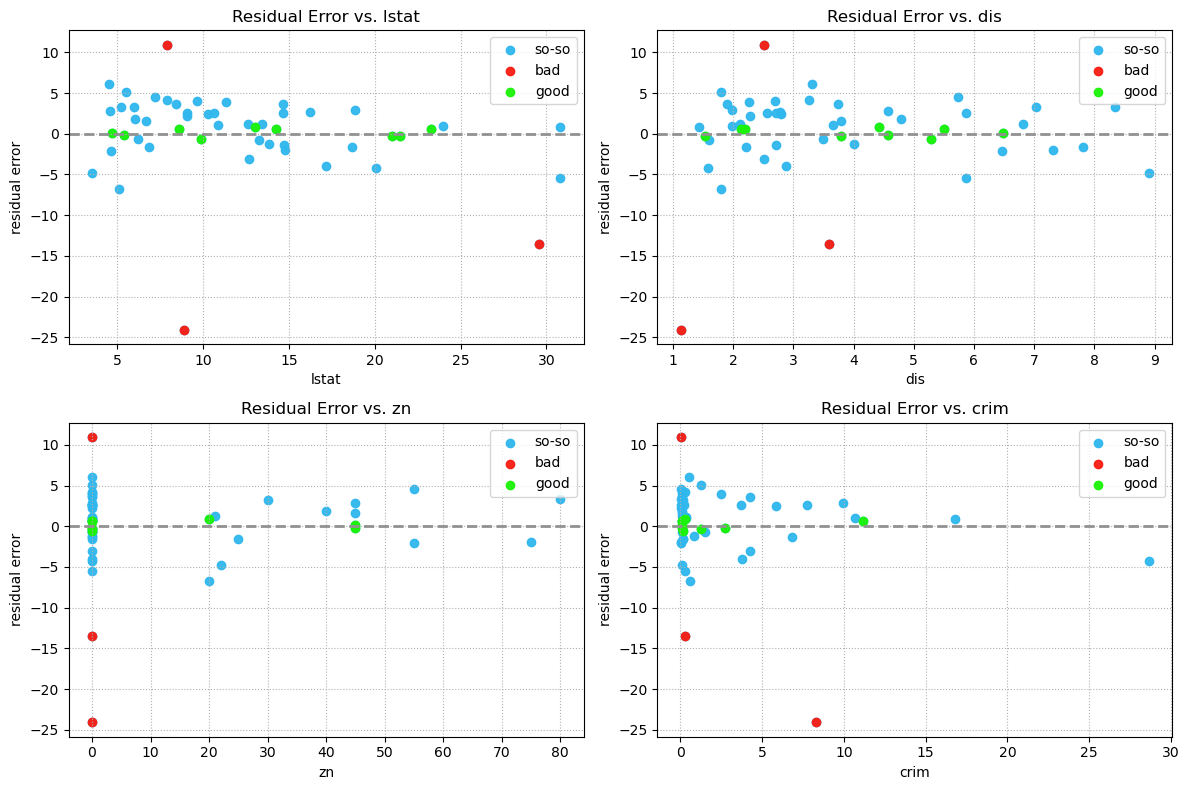

In [29]:
features = ['lstat', 'dis', 'zn', 'crim']
features = np.array(features).reshape((2,2))
res_and_others(df_test, Y_test_predict, Y_test, features)

- lstat: behave badly on two side, but well in the middle. Thus a quadratic function is needed to be introduced.
- dis/crim: have Heteroskedasticity(异方差), perform badly when small, gradually become normal when getting bigger. Thus they need a logarithmic function
- zn: all the extreme biases happen when zn=0, it is also important, because it distinguish situations with zn=0 and zn != 0

We first add $\text{lstat}^{2}$ to dataset.

In [30]:
# remove those extrem value
drop_out = [373, 215, 506, 365, 254, 375]

In [31]:
def model(lamda=20, lstat_sq=False, dp_zn=False, lg_dis=False, lg_crim=False, random_state=42):
    df = pd.read_csv("assets/Boston.csv", index_col=0)
    df = df.drop(index=drop_out) # dropout those ourliers

    if lstat_sq:
        df['lstat_sq'] = df['lstat'] ** 2

    if dp_zn:
        df = df.drop(columns='zn')
    
    if lg_dis:
        df['dis_lg'] = np.log1p(df['dis'])

    if lg_crim:
        df['dis_lg'] = np.log1p(df['crim'])

    df_drop_and_shuffle = drop_and_shuffle(df, drop_colums=[], random_state=42)
    df_splits = df_split(df_drop_and_shuffle, train_ratio=0.7, dev_ratio=0.2)
    df_train, df_dev, df_test = df_splits

    X_train, Y_train = set_split_to_array(df_train, drop_feature=['medv'])
    X_dev, Y_dev = set_split_to_array(df_dev, drop_feature=['medv'])
    X_test, Y_test = set_split_to_array(df_test, drop_feature=['medv'])
    X_list = [X_train, X_dev, X_test]
    Y_list = [Y_train, Y_dev, Y_test]

    process, cache = linear_regression(
    X_train, Y_train, 
    iterations = 100000, 
    learning_rate = 0.001, 
    lamda = lamda)

    train_data_plot(process)

    res = evaluation(X_list, Y_list, cache, test=True)
    Y_train_predict, Y_dev_predict, Y_test_predict = list(res["predict"].values())

    features_2 = ['predict', 'lstat', 'medv', 'dis', 'zn', 'crim', ]
    features_2 = np.array(features_2).reshape((2,3))
    res_and_others(df_test, Y_test_predict, Y_test, features_2)
    return cache

1th iteration, cost = 0.499999999892184
1001th iteration, cost = 0.16372528361246794
2001th iteration, cost = 0.149714705867215
3001th iteration, cost = 0.1451458357315611
4001th iteration, cost = 0.14238072040790406
5001th iteration, cost = 0.14042490572834015
6001th iteration, cost = 0.13897745174798434
7001th iteration, cost = 0.13787968244646095
8001th iteration, cost = 0.13703162262530882
9001th iteration, cost = 0.1363663708059074
10001th iteration, cost = 0.13583771757008722
11001th iteration, cost = 0.13541298975114888
12001th iteration, cost = 0.13506860921160851
13001th iteration, cost = 0.13478723634774445
14001th iteration, cost = 0.13455589071045987
15001th iteration, cost = 0.13436469251028232
16001th iteration, cost = 0.13420600646115902
17001th iteration, cost = 0.13407385028754992
18001th iteration, cost = 0.13396347963748254
19001th iteration, cost = 0.1338710920798989
20001th iteration, cost = 0.13379361254294234
21001th iteration, cost = 0.13372853521522776
22001th 

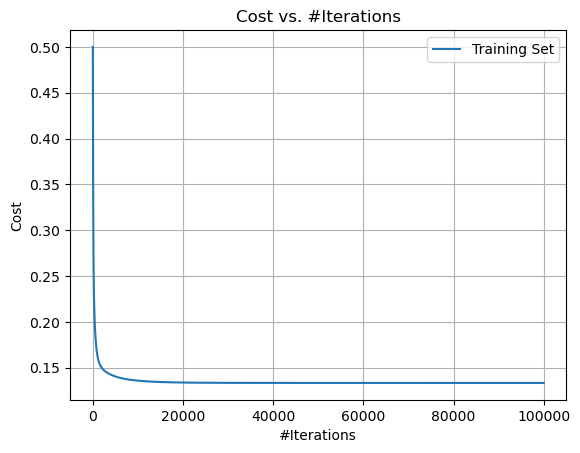

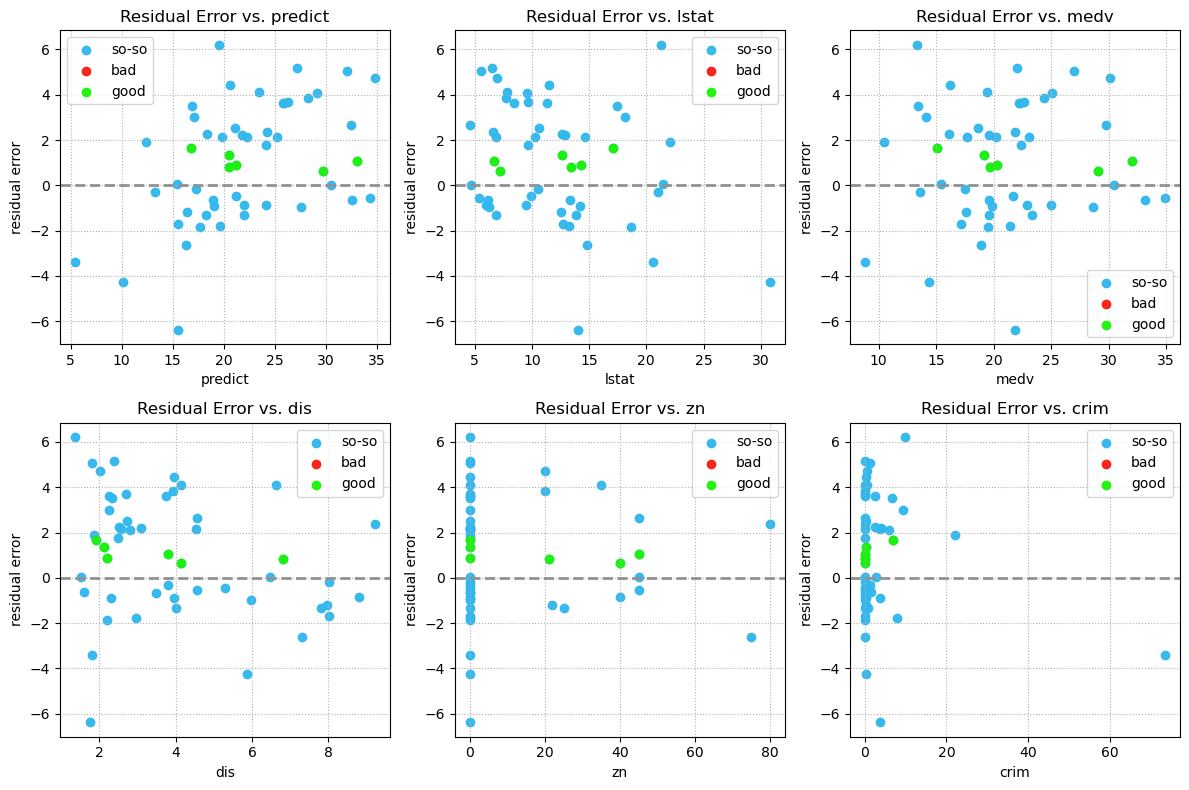

In [32]:
cache = model(
    lamda = 20,
    lstat_sq = True,
    random_state = 42
    )

Result:
|Catagory|$R^{2}$|$RMSE$|
|:-------|:------|:-----|
|Train   |0.7726 |4.4234|
|Dev     |0.7995 |4.3541|
|Test    |0.7605 |2.7870|

NO MORE OVERFITTING!!!

So, thats all, we trained a splendid model. 

### Conclusion
This marks my first attempt to approach the introductory machine learning concept of linear regression with the seriousness of a proper assignment or project.

I first encountered linear regression on Kaggle three months ago. Back then, I was only able to clumsily invoke the `sklearn` API, constantly having to look up the syntax. That's when I first realized how utterly superficial the so-called linear regression and least squares methods I learned in high school were. I also became aware of the power of data: the data holds all the answers, but discerning those answers is another matter entirely.

The entire project, completed with the assistance of AI, took two and a half days. I reviewed the fundamental principles of linear regression, constructed a basic model, and recalled the necessity of introducing L2 regularization to mitigate overfitting. This time, I also manually plotted the gradient descent curve and the residual distribution chart. I encountered the coefficient of determination (R-squared), which brought me both great joy and a sense of shame, as I had, in fact, studied this concept in high school.

An unexpected situation arose during model training: the model actually overfit the development set. Initially, I was ecstatic, thinking I had built a perfect model, only to be harshly brought back to reality by the abysmal results when applied to the test set. Consequently, subsequent operations in this project, such as introducing new features, were performed while "peeking" at the test set results—which I admit is cheating.

Next time, I will stick to my resolve and not touch the test set until the very final stage. I will use the residual plots exclusively on the development set and refrain from presumptuously deleting features early on. I also plan to experiment with techniques such as cross-validation and Principal Component Analysis (PCA).

In short, this project gave me the chance to encounter various real-world pitfalls—lessons that are impossible to truly learn simply by watching tutorials, copying code, or relying on high-level libraries like `sklearn`. If you are a fellow beginner interested in machine learning, I highly recommend:

- Before using mature libraries, manually implement the models you learn using NumPy.
- Gain at least a basic understanding of statistics and linear algebra; the underlying math is truly important.